# Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("/kaggle/src")

import warnings
warnings.simplefilter('ignore', FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import polars as pl
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

from common.constant import TRAIN_CSV_PATH
from eda_utils import boxplot_sii, lineplot_age
from preprocess.table import label_edit

# Data

In [3]:
trn_df = label_edit(pl.read_csv(TRAIN_CSV_PATH))
# trn_df = (
#     trn_df
#     .with_columns((pl.col("Physical-Height") * 2.54).alias("Physical-Height"))
#     .with_columns((pl.col("Physical-Weight") * 0.45).alias("Physical-Weight"))
#     .with_columns((pl.col("Physical-Waist_Circumference") * 2.54).alias("Physical-Waist_Circumference"))
# )
print(trn_df.shape)
trn_df.head()

(3960, 82)


id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,str,i64,i64,str,i64,str,f64,f64,f64,f64,i64,i64,i64,str,i64,i64,i64,str,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,str,i64,f64,f64,…,f64,f64,f64,f64,f64,str,f64,str,f64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,i32
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,…,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,…,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,…,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


# Exploratory data analysis

In [250]:
trn_df.describe()

statistic,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,str,str,f64,f64,str,f64,str,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,…,f64,f64,f64,f64,f64,str,f64,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,str,f64,f64
"""count""","""3960""","""3960""",3960.0,3960.0,"""2555""",2421.0,"""3310""",3022.0,3027.0,3076.0,898.0,2954.0,2967.0,2954.0,"""1308""",743.0,740.0,740.0,"""3346""",2322.0,2282.0,1074.0,1062.0,1074.0,1063.0,2310.0,2271.0,2305.0,2267.0,2307.0,2269.0,2324.0,2285.0,"""2145""",1991.0,1991.0,…,1991.0,1991.0,1991.0,1991.0,1991.0,"""475""",475.0,"""1721""",1721.0,"""2736""",2734.0,2734.0,2734.0,2734.0,2734.0,2734.0,2734.0,2734.0,2734.0,2734.0,2735.0,2735.0,2735.0,2735.0,2735.0,2735.0,2735.0,2735.0,2735.0,2735.0,2734.0,"""2618""",2609.0,2606.0,"""3540""",3301.0,2734.0
"""null_count""","""0""","""0""",0.0,0.0,"""1405""",1539.0,"""650""",938.0,933.0,884.0,3062.0,1006.0,993.0,1006.0,"""2652""",3217.0,3220.0,3220.0,"""614""",1638.0,1678.0,2886.0,2898.0,2886.0,2897.0,1650.0,1689.0,1655.0,1693.0,1653.0,1691.0,1636.0,1675.0,"""1815""",1969.0,1969.0,…,1969.0,1969.0,1969.0,1969.0,1969.0,"""3485""",3485.0,"""2239""",2239.0,"""1224""",1226.0,1226.0,1226.0,1226.0,1226.0,1226.0,1226.0,1226.0,1226.0,1226.0,1225.0,1225.0,1225.0,1225.0,1225.0,1225.0,1225.0,1225.0,1225.0,1225.0,1226.0,"""1342""",1351.0,1354.0,"""420""",659.0,1226.0
"""mean""",null,null,10.433586,0.372727,null,65.454771,null,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,null,4.989233,7.37027,27.581081,null,11.25969,0.476337,22.420438,1.829567,23.518622,1.904045,5.579654,0.330251,8.694924,0.61888,8.805635,0.620097,9.252775,0.785558,null,2.651431,6.719826,…,33.17338,20.02299,67.301883,34.389466,53.998726,null,2.178853,null,2.58955,null,2.370885,2.177762,2.400878,0.840161,2.29883,1.064009,0.58632,1.247257,1.06218,1.305048,1.685923,0.244973,1.340402,1.035832,1.500183,1.453382,1.632176,1.615356,1.160512,0.944424,28.002195,null,41.088923,57.763622,null,1.060588,0.58376
"""std""",null,null,3.574648,0.483591,null,22.341862,null,5.113934,7.473764,44.56904,5.567287,13.611226,13.665196,17.061225,null,2.014072,3.189662,17.707751,null,11.807781,0.499549,10.833995,0.612585,11.148951,0.612344,7.390161,0.470407,3.429301,0.485769,3.422167,0.485469,2.988863,0.410525,null,1.028267,92.586325,…,56.272346,70.21561,108.705918,84.050607,129.362539,null,0.849476,null,0.783937,null,1.673049,1.697117,1.588312,1.195361,1.704566,1.268522,1.048604,1.341839,1.258041,1.331538,1.542996,0.523014,1.41008,1.301691,1.492452,1.494663,1.447442,1.528725,1.34373,1.185679,20.376245,null,10.427433,13.196091,null,1.094875,0.773774
"""min""","""00008ff9""","""Fall""",5.0,0.0,"""Fall""",25.0,"""Fall""",0.0,33.0,0.0,18.0,0.0,27.0,0.0,"""Fall""",0.0,0.0,0.0

### Basic_Demos-Age

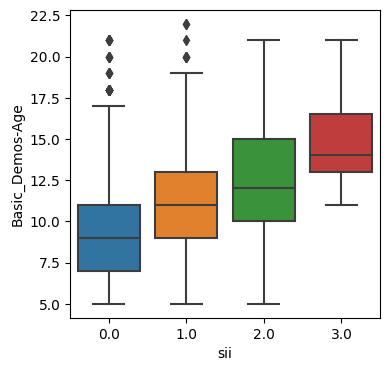

In [52]:
boxplot_sii(trn_df, "Basic_Demos-Age")

### CGAS-CGAS_Score

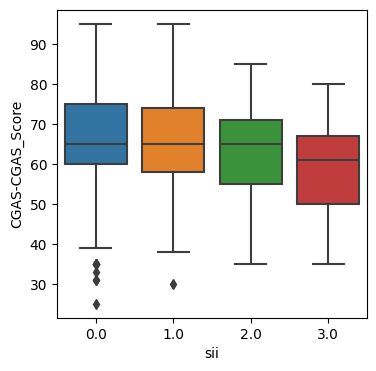

In [53]:
boxplot_sii(trn_df, "CGAS-CGAS_Score")

In [15]:
trn_df.filter(pl.col("CGAS-CGAS_Score") > 100)

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,str,i64,i64,str,i64,str,f64,f64,f64,f64,i64,i64,i64,str,i64,i64,i64,str,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,str,i64,f64,f64,…,f64,f64,f64,f64,f64,str,f64,str,f64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,i32
"""83525bbe""","""Fall""",11,1,"""Winter""",999,"""Fall""",null,null,null,null,null,null,null,"""Fall""",null,null,null,"""Fall""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,"""Fall""",2.241,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Fall""",3,null


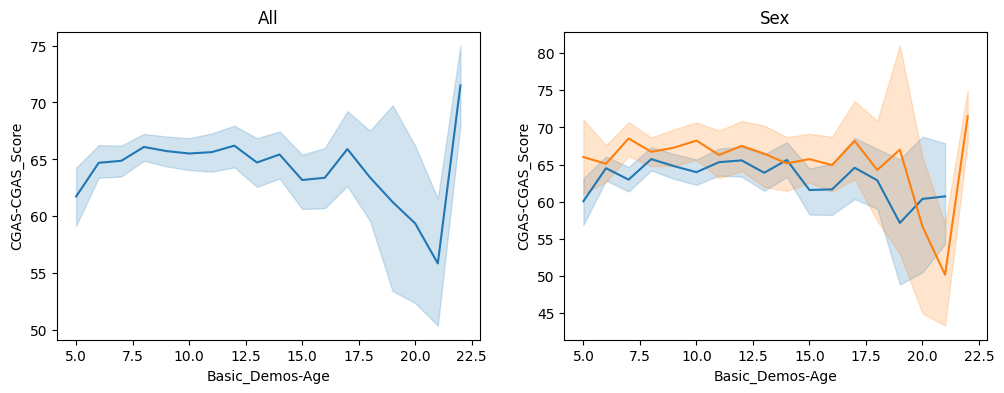

In [9]:
lineplot_age(trn_df.filter(pl.col("CGAS-CGAS_Score") < 100), "CGAS-CGAS_Score")

## Physical columns

In [143]:
physical_cols = [col for col in trn_df.columns if ("Physical" in col) & ("Season" not in col)]
len(physical_cols)

7

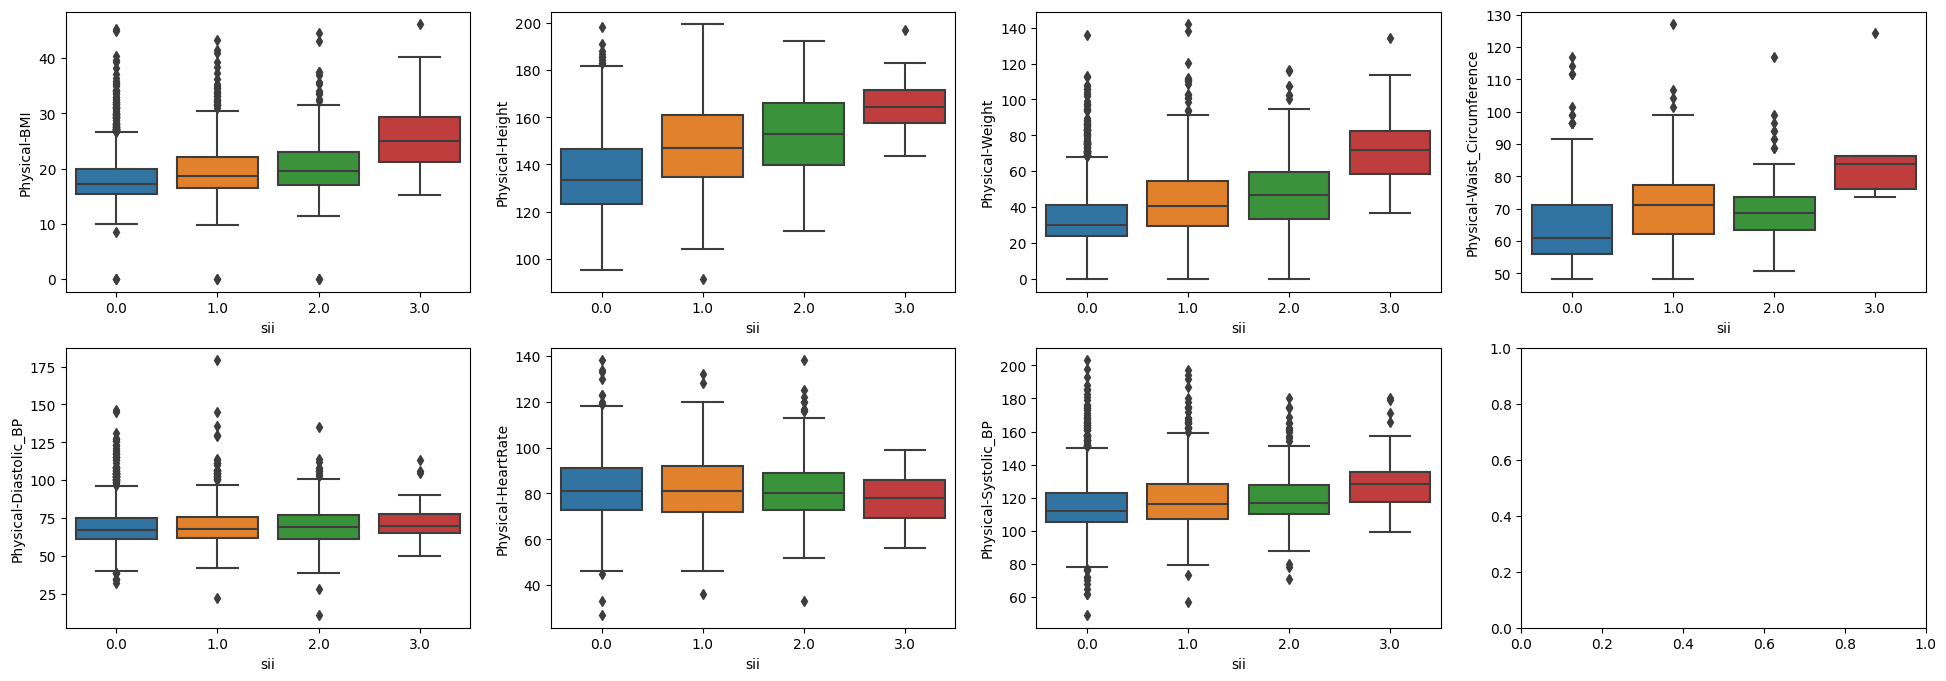

In [142]:
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
axes = axes.flatten()
for i, col in enumerate(physical_cols):
    sns.boxplot(x="sii", y=col, data=trn_df.to_pandas(), ax=axes[i])

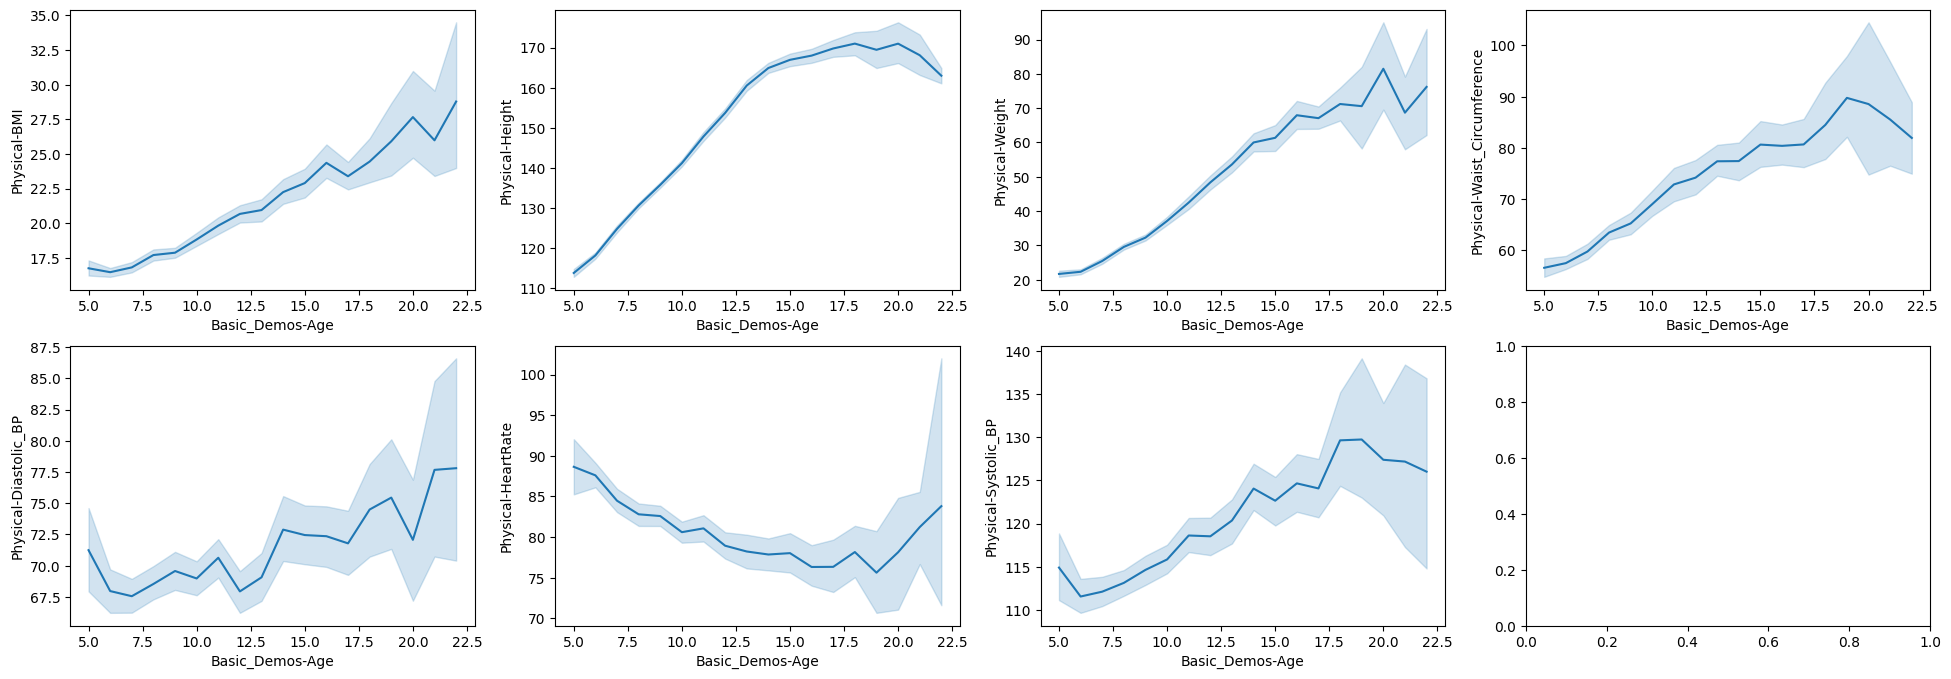

In [144]:
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
axes = axes.flatten()
for i, col in enumerate(physical_cols):
    sns.lineplot(x="Basic_Demos-Age", y=col, data=trn_df.to_pandas(), ax=axes[i])

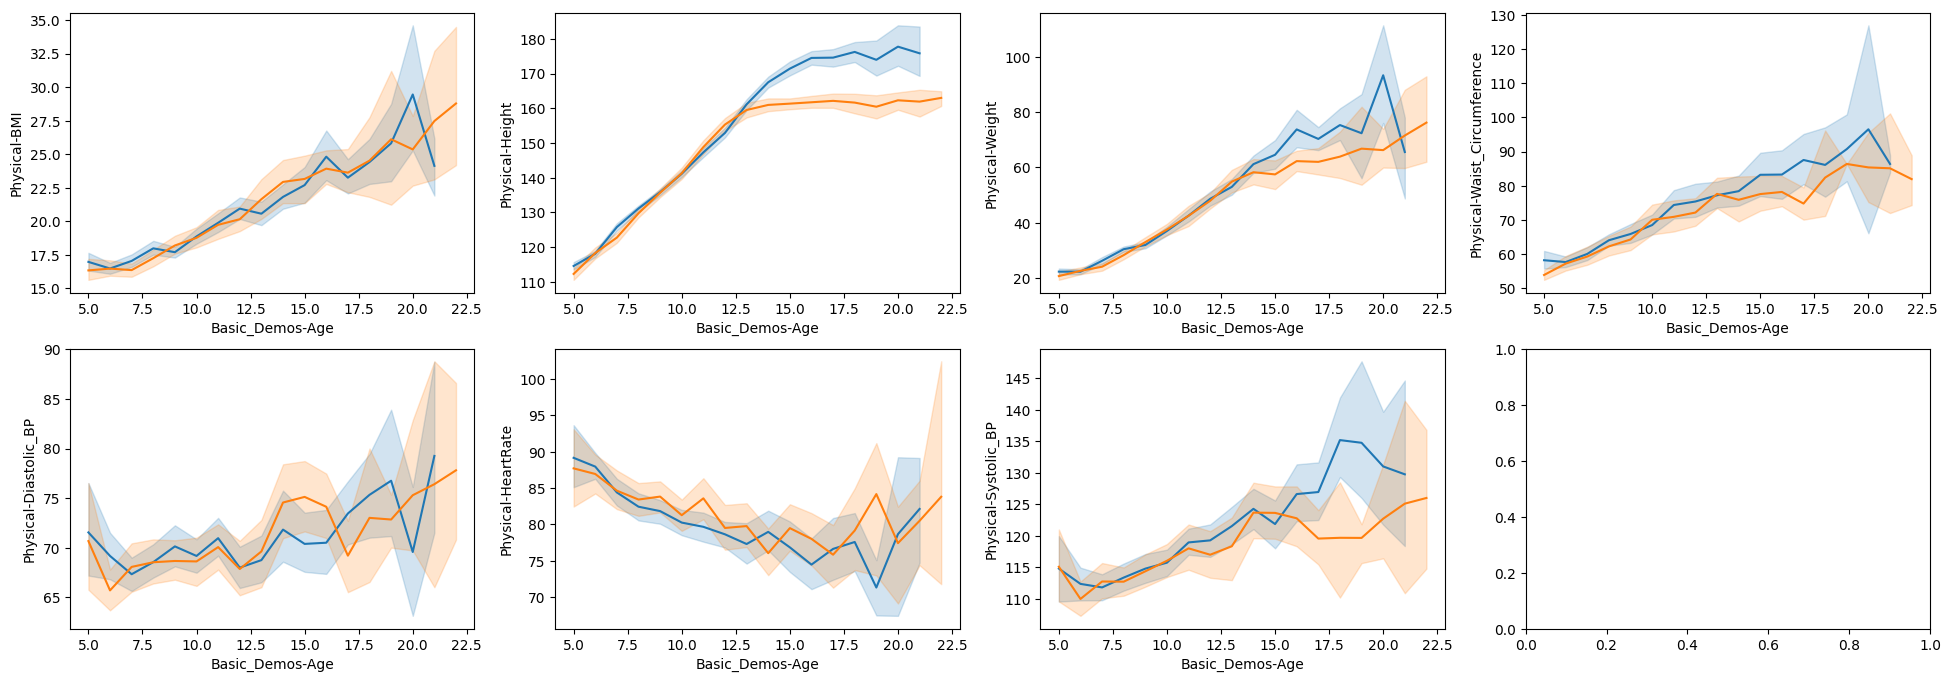

In [145]:
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
axes = axes.flatten()
for i, col in enumerate(physical_cols):
    sns.lineplot(x="Basic_Demos-Age", y=col, data=trn_df.filter(pl.col("Basic_Demos-Sex") == 0).to_pandas(), ax=axes[i])
    sns.lineplot(x="Basic_Demos-Age", y=col, data=trn_df.filter(pl.col("Basic_Demos-Sex") == 1).to_pandas(), ax=axes[i])

### Physical-BMI

In [147]:
# Outlier
len(trn_df.filter(pl.col("Physical-BMI") == 0))

7

### Physical-Weight

In [235]:
# Outlier
print(len(trn_df.filter(pl.col("Physical-Weight") == 0)))
trn_df.filter(pl.col("Physical-Weight") == 0)

61


id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,str,i64,i64,str,i64,str,f64,f64,f64,f64,i64,i64,i64,str,i64,i64,i64,str,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,str,i64,f64,f64,…,f64,f64,f64,f64,f64,str,f64,str,f64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,i32
"""026102c4""","""Fall""",7,1,"""Summer""",66,"""Summer""",null,null,0.0,null,null,null,null,null,null,null,null,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,"""Fall""",2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,21,"""Fall""",33,47,"""Fall""",0,0
"""0632d98a""","""Spring""",11,0,"""Summer""",70,"""Spring""",null,null,0.0,null,null,null,null,null,null,null,null,"""Spring""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,"""Spring""",2.86,"""Spring""",0,0,1,1,2,1,0,0,1,1,2,0,1,1,1,1,1,1,1,1,17,"""Spring""",33,47,"""Spring""",0,0
"""0b6b07f6""","""Winter""",8,1,null,null,"""Summer""",null,null,0.0,null,null,null,null,null,null,null,null,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,"""Spring""",1.17,"""Spring""",2,2,3,2,3,1,0,2,0,1,2,0,2,2,1,0,2,1,0,0,26,"""Spring""",32,46,"""Winter""",null,0
"""0c83af0f""","""Summer""",13,1,null,null,"""Fall""",0.0,144.145,0.0,null,75,73,121,null,null,null,null,"""Spring""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,"""Fall""",1.64,"""Fall""",4,4,4,0,4,3,0,4,2,2,3,0,1,4,1,2,3,3,4,4,52,"""Fall""",43,60,"""Summer""",0,2
"""0df44f9e""","""Summer""",15,1,"""Winter""",65,"""Fall""",null,null,0.0,null,null,null,null,null,null,null,null,"""Fall""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,"""Fall""",1.12,null,null,"""Fall""",5,5,5,2,4,4,1,2,5,3,4,1,4,1,1,5,2,4,0,1,59,"""Fall""",44,62,"""Summer""",3,2
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""eb9a846d""","""Spring""",6,0,"""Fall""",61,"""Spring""",null,null,0.0,null,null,null,null,null,null,null,null,"""Spring""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,"""Spring""",4,0,4,0,4,0,0,4,0,2,2,0,0,2,2,1,2,0,0,1,28,"""Spring""",44,62,"""Spring""",2,0
"""ef3a2d17""","""Spring""",10,0,null,null,"""Fall""",null,null,0.0,null,null,null,null,null,null,null,null,"""Fall""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,

### Physical-Diastolic_BP, Physical-Systoloc_BP

In [149]:
# Outlier
len(trn_df.filter((pl.col("Physical-Diastolic_BP") == 0) | (pl.col("Physical-Systolic_BP") == 0)))

1

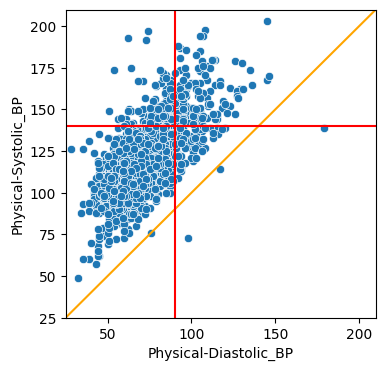

In [94]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x="Physical-Diastolic_BP", y="Physical-Systolic_BP", data=trn_df.to_pandas())
plt.plot(np.linspace(25, 210, 500), np.linspace(25, 210, 500), color="orange")
plt.hlines(140, xmin=25, xmax=210, colors="red")
plt.vlines(90, ymin=25, ymax=210, colors="red")
plt.xlim(25, 210)
plt.ylim(25, 210)
plt.show()

## Fitness_Endurance cols

### Fitness_Endurance-Max_Stage

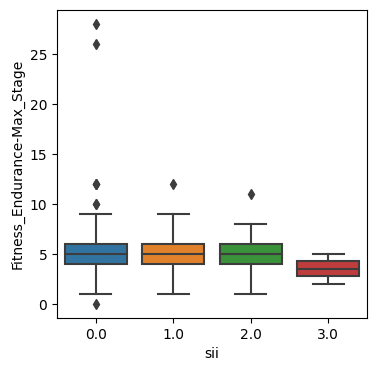

In [103]:
boxplot_sii(trn_df, "Fitness_Endurance-Max_Stage")

In [113]:
trn_df.filter(pl.col("Fitness_Endurance-Max_Stage") > 15)

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,str,i64,i64,str,i64,str,f64,f64,f64,f64,i64,i64,i64,str,i64,i64,i64,str,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,str,i64,f64,f64,…,f64,f64,f64,f64,f64,str,f64,str,f64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,i32
"""5c186496""","""Winter""",7,1,"""Spring""",80,"""Winter""",16.480209,132.715,28.8,null,74,74,111,"""Winter""",26,null,null,"""Spring""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",3,2.75116,16.482,…,22.0857,16.5249,48.7616,21.6996,34.9879,null,null,null,null,"""Spring""",1,2,3,0,2,0,0,0,1,0,0,0,1,1,3,2,2,1,0,0,19,"""Spring""",40,56,"""Winter""",0,0
"""f2499682""","""Winter""",8,0,"""Summer""",60,"""Spring""",16.811457,129.54,27.99,null,61,80,109,"""Spring""",28,8,12,"""Spring""",20,1,null,null,null,null,20,1,9.5,1,10.5,1,9.0,1,"""Spring""",3,3.39579,16.8133,…,30.5769,11.1919,50.4807,32.996,42.6845,null,null,"""Winter""",3.02,"""Spring""",3,0,3,1,3,1,0,1,1,0,0,0,2,1,3,3,2,2,1,0,27,"""Spring""",38,54,"""Winter""",0,0


In [112]:
trn_df.filter(pl.col("Fitness_Endurance-Max_Stage").is_not_null())["Basic_Demos-Age"].value_counts().sort("Basic_Demos-Age")

Basic_Demos-Age,count
i64,u32
6,77
7,129
8,134
9,148
10,138
11,87
12,30


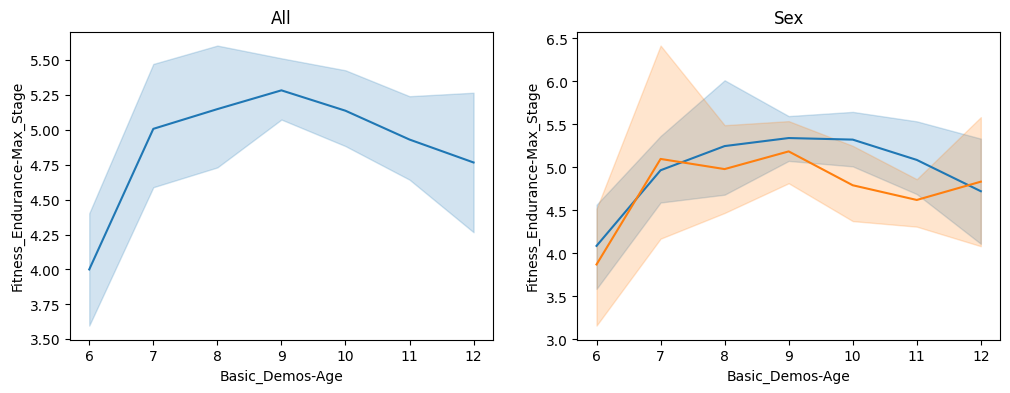

In [105]:
lineplot_age(trn_df, "Fitness_Endurance-Max_Stage")

### Fitness_Endurance-Time

In [119]:
eda = (
    trn_df
    .with_columns(
        (pl.col("Fitness_Endurance-Time_Mins") + pl.col("Fitness_Endurance-Time_Sec") / 60).alias("Fitness_Endurance-Time")
    )
)

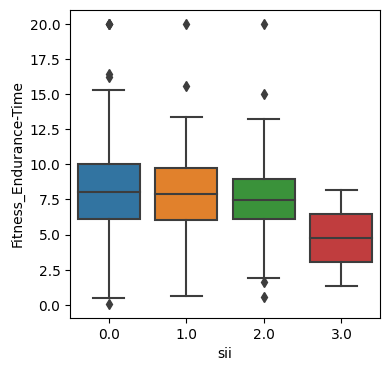

In [120]:
boxplot_sii(eda, "Fitness_Endurance-Time")

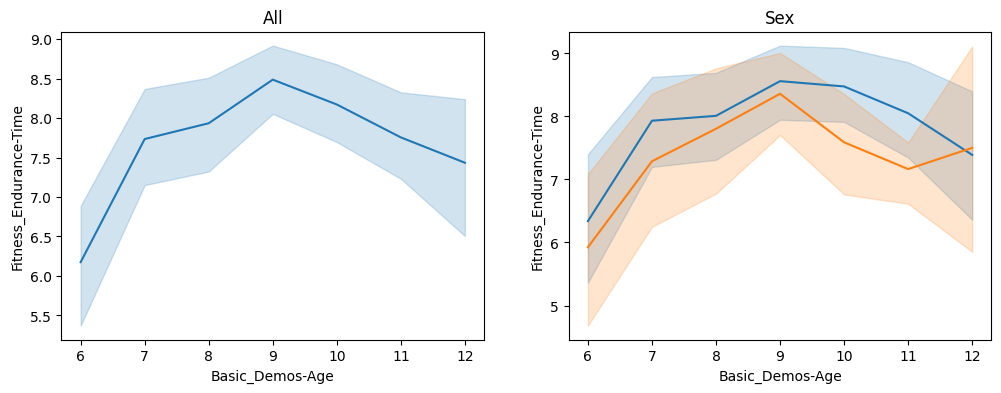

In [121]:
lineplot_age(eda, "Fitness_Endurance-Time")

## FGC cols

In [158]:
fgc_cols = [col for col in trn_df.columns if ("FGC" in col) & ("Season" not in col) & ("Zone" not in col)]
fgc_zone_cols = [col for col in trn_df.columns if ("FGC" in col) & ("Zone" in col)]
print("FGC", len(fgc_cols), ",", "FGC_Zone", len(fgc_zone_cols))

FGC 7 , FGC_Zone 7


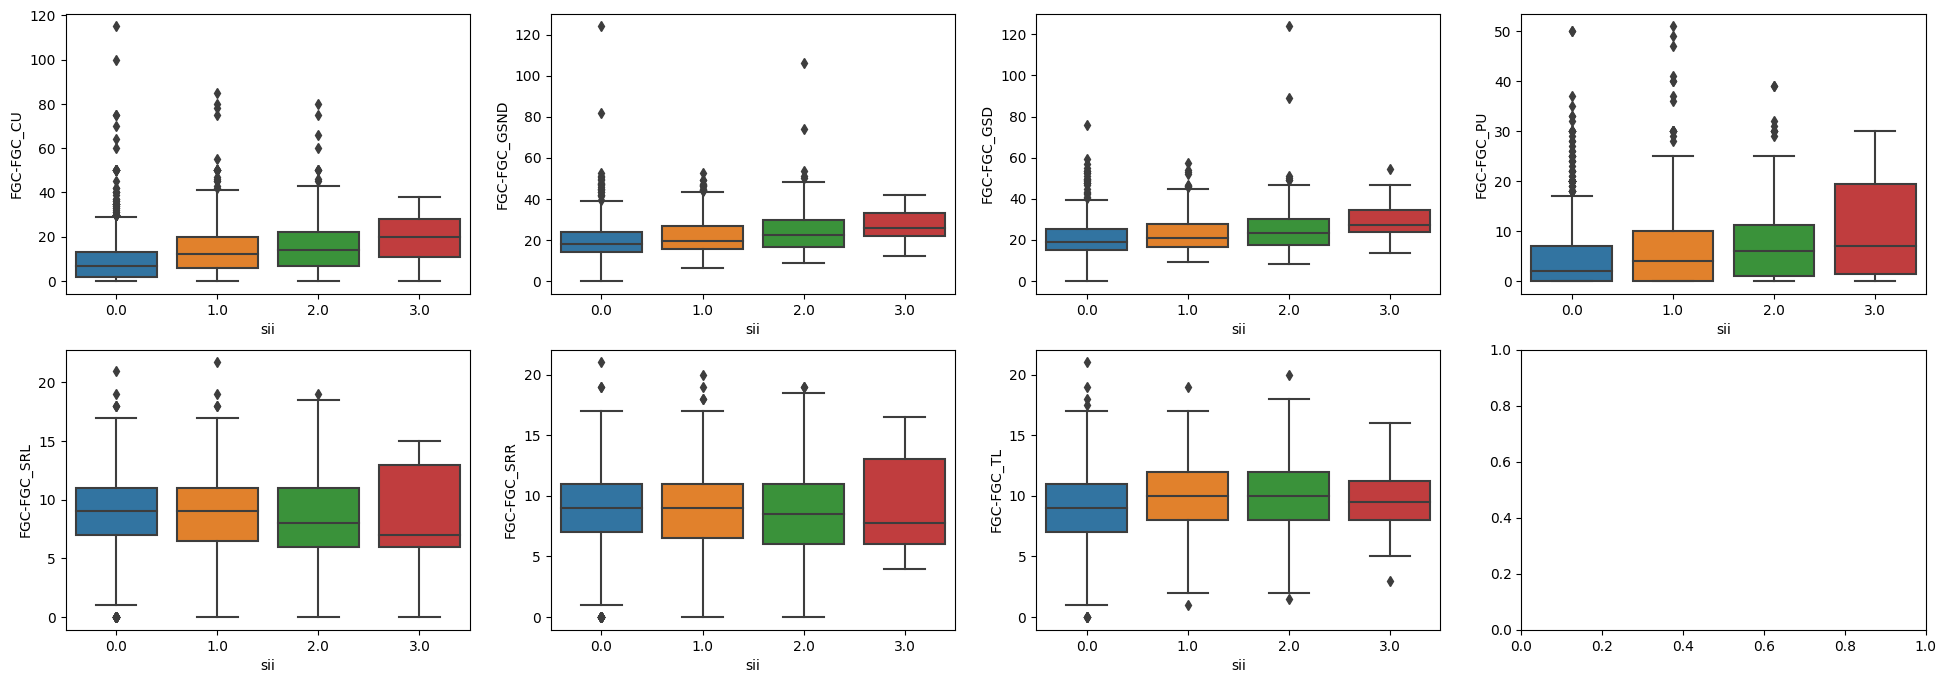

In [155]:
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
axes = axes.flatten()
for i, col in enumerate(fgc_cols):
    sns.boxplot(x="sii", y=col, data=trn_df.to_pandas(), ax=axes[i])

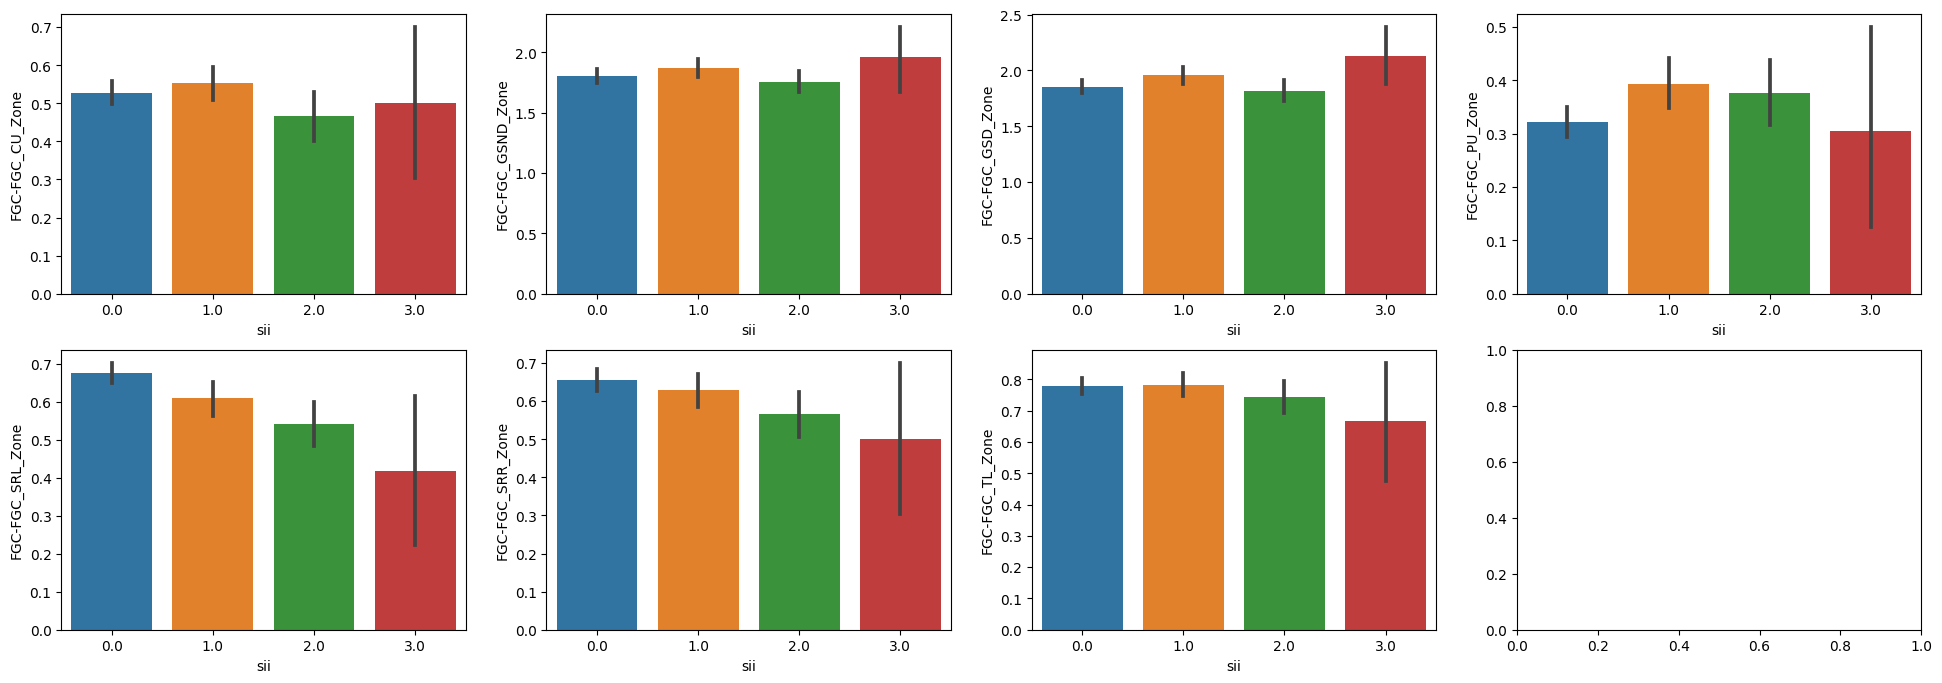

In [159]:
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
axes = axes.flatten()
for i, col in enumerate(fgc_zone_cols):
    sns.barplot(x="sii", y=col, data=trn_df.to_pandas(), ax=axes[i])

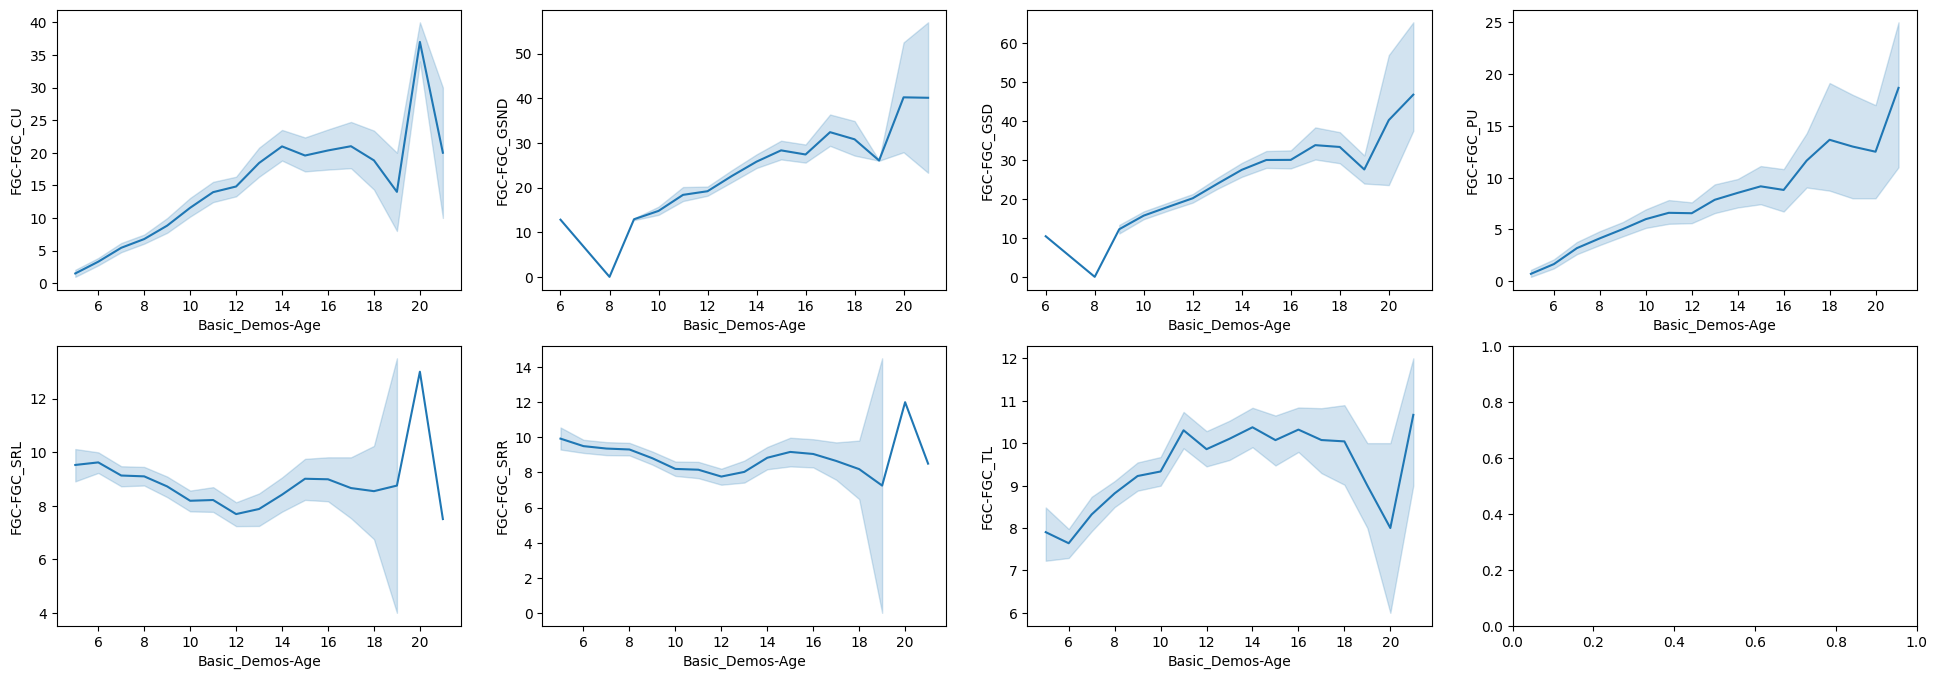

In [160]:
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
axes = axes.flatten()
for i, col in enumerate(fgc_cols):
    sns.lineplot(x="Basic_Demos-Age", y=col, data=trn_df.to_pandas(), ax=axes[i])

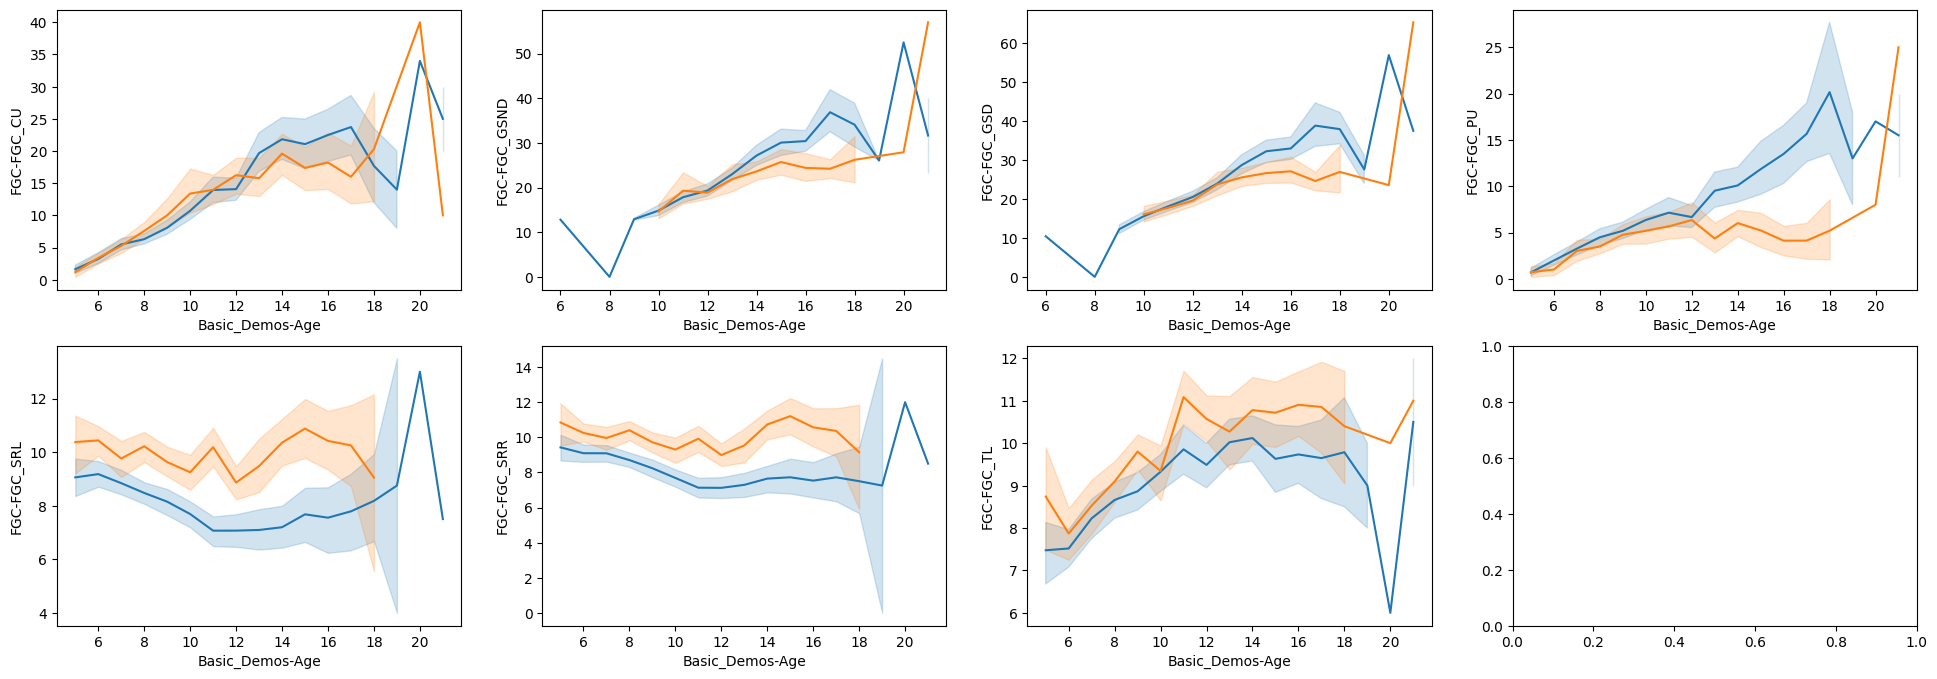

In [161]:
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
axes = axes.flatten()
for i, col in enumerate(fgc_cols):
    sns.lineplot(x="Basic_Demos-Age", y=col, data=trn_df.filter(pl.col("Basic_Demos-Sex") == 0).to_pandas(), ax=axes[i])
    sns.lineplot(x="Basic_Demos-Age", y=col, data=trn_df.filter(pl.col("Basic_Demos-Sex") == 1).to_pandas(), ax=axes[i])

## BIA cols

In [163]:
bia_cols = [col for col in trn_df.columns if ("BIA" in col) & ("Season" not in col)]
len(bia_cols)

16

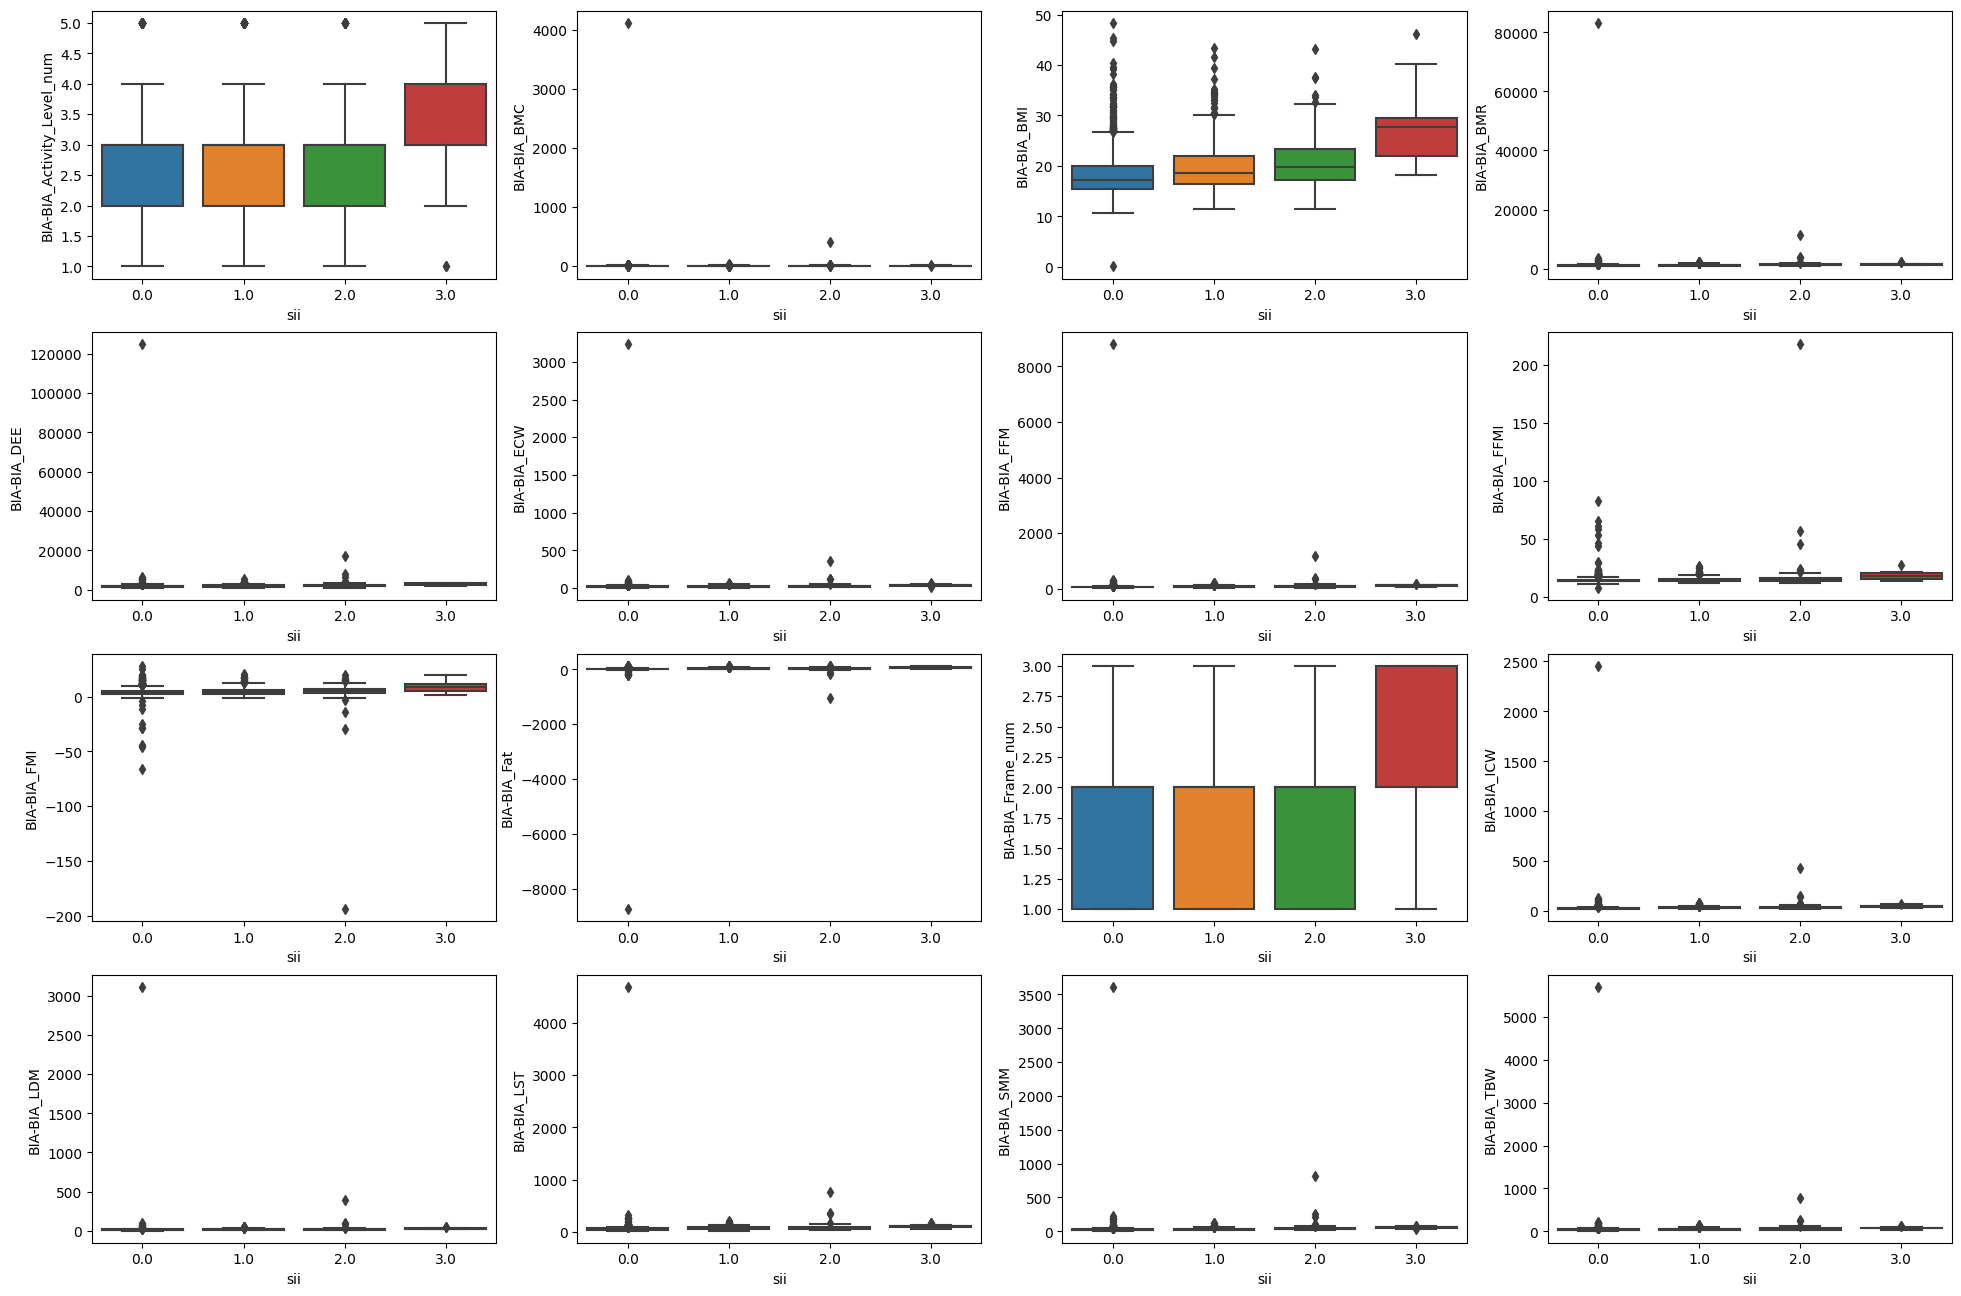

In [164]:
fig, axes = plt.subplots(4, 4, figsize=(24, 16))
axes = axes.flatten()
for i, col in enumerate(bia_cols):
    sns.boxplot(x="sii", y=col, data=trn_df.to_pandas(), ax=axes[i])

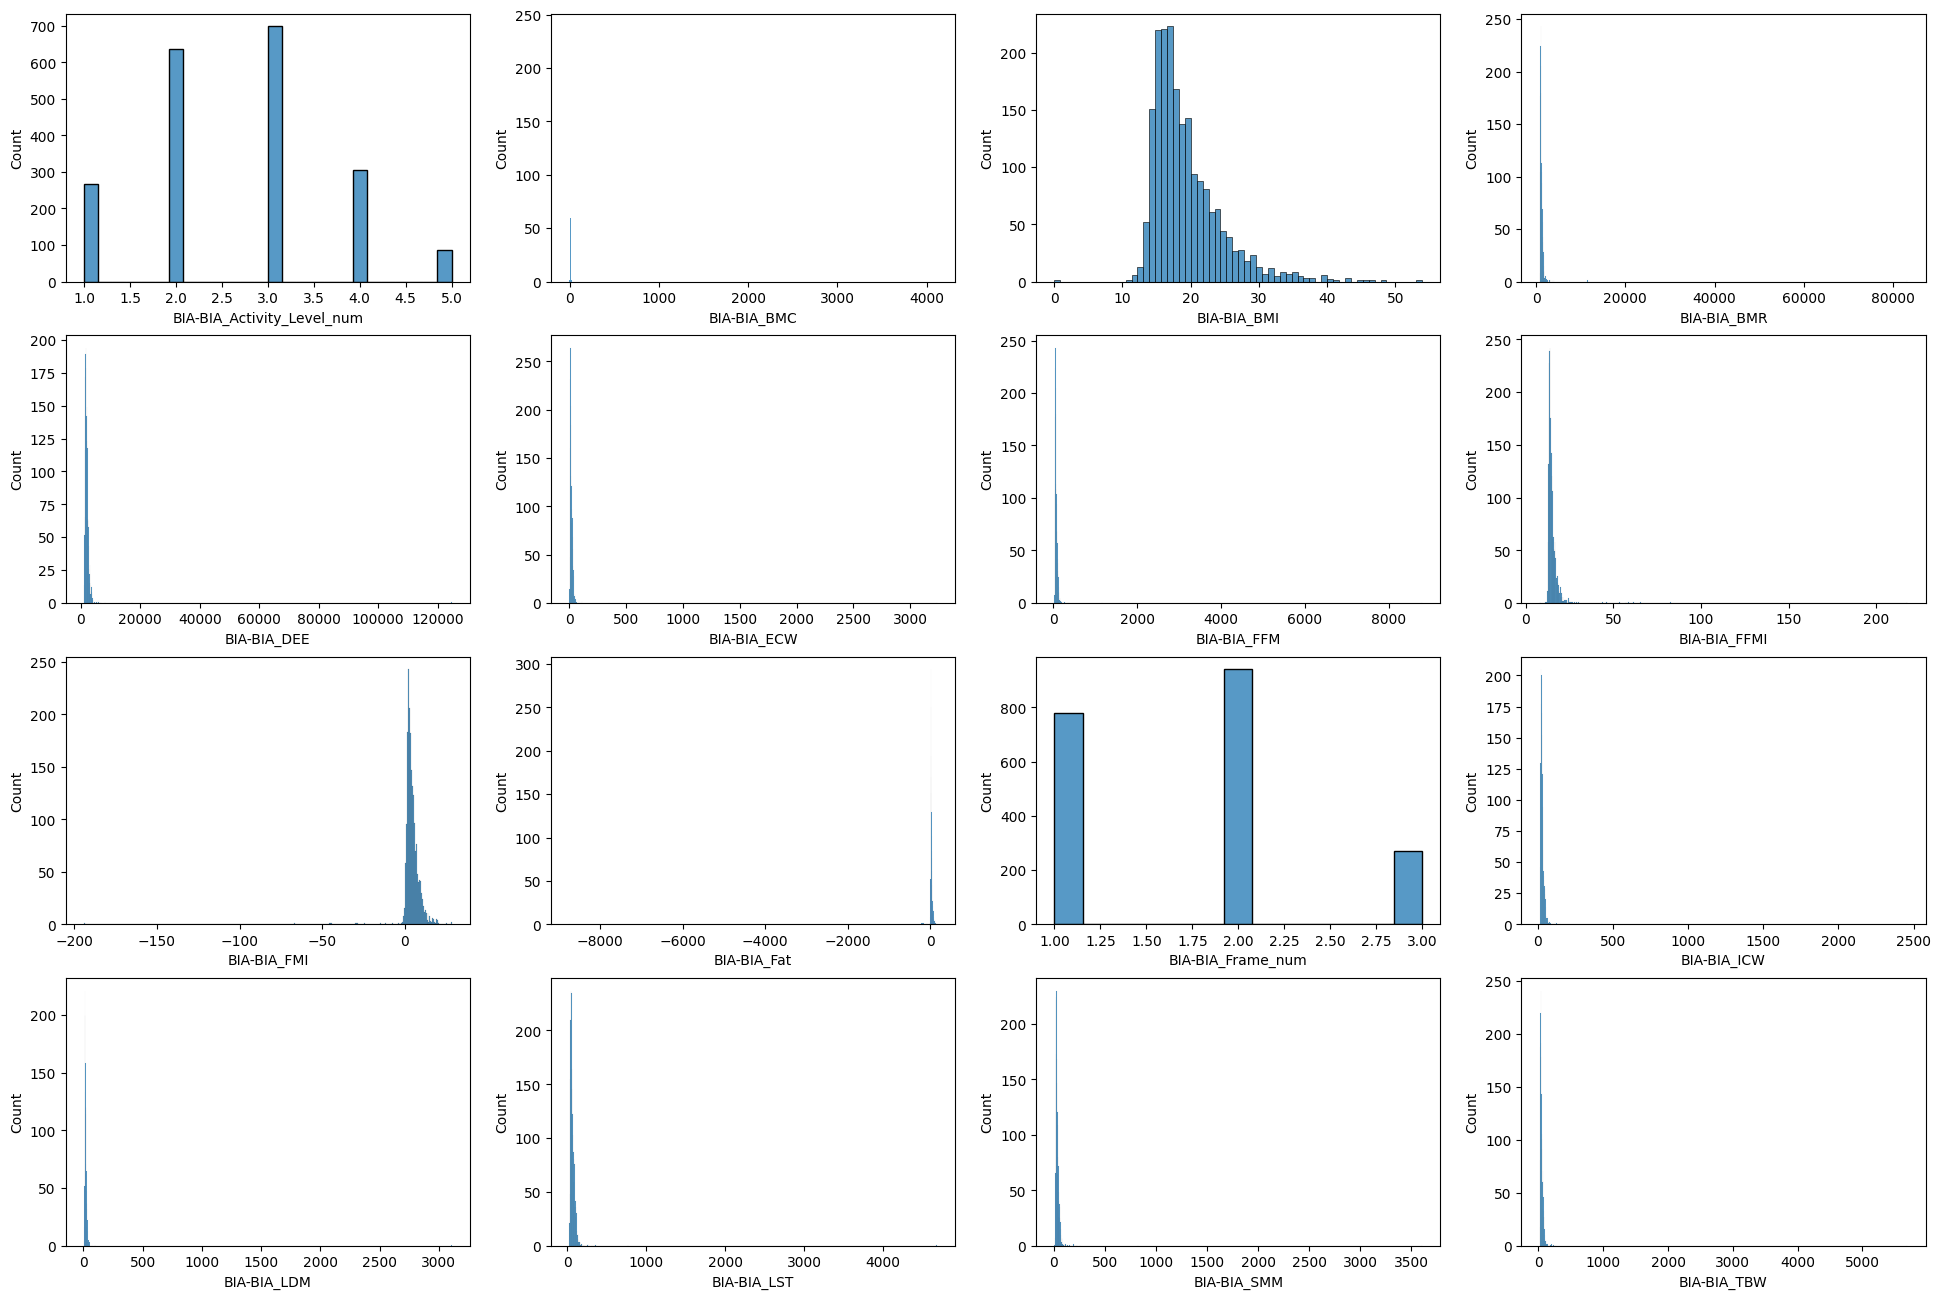

In [193]:
fig, axes = plt.subplots(4, 4, figsize=(24, 16))
axes = axes.flatten()
for i, col in enumerate(bia_cols):
    sns.histplot(x=col, data=trn_df.to_pandas(), ax=axes[i])

In [220]:
# Outlier
trn_df.filter((pl.col("BIA-BIA_BMC") > 1000) | (pl.col("BIA-BIA_FFMI") > 200)).select(bia_cols)

BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64
2,4115.36,0.0482667,83152.2,124728.0,3233.0,8799.08,7.86485,-7.81659,-8745.08,2,2457.91,3108.17,4683.71,3607.69,5690.91
2,401.002,23.6078,11540.8,17311.2,350.849,1171.51,217.771,-194.163,-1044.51,2,428.264,392.4,770.511,823.028,779.114


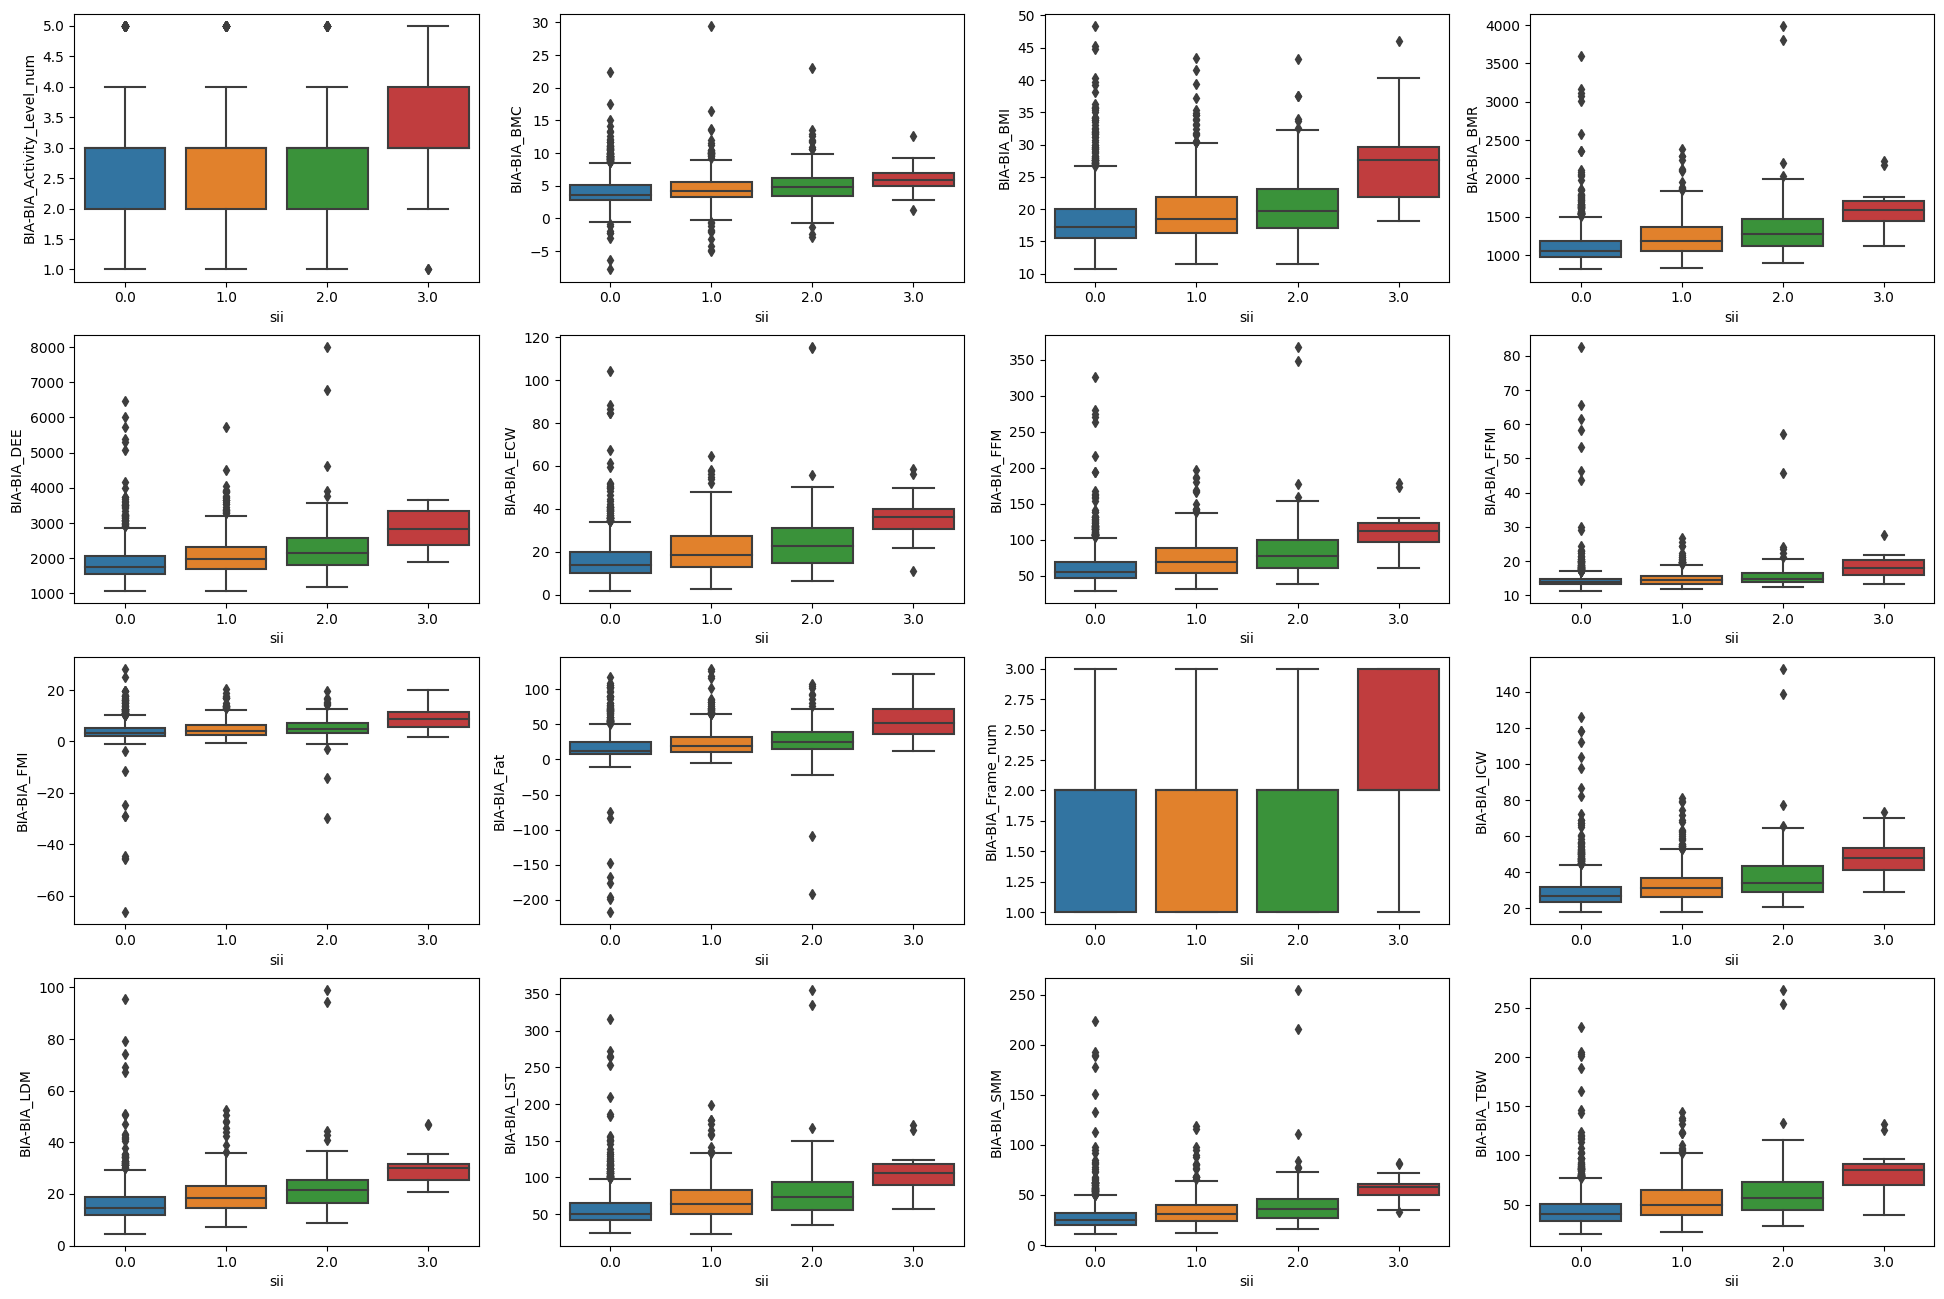

In [175]:
rm_id = trn_df.filter((pl.col("BIA-BIA_BMC") > 1000) | (pl.col("BIA-BIA_FFMI") > 200))["id"].to_list()
eda = trn_df.filter(pl.col("id").is_in(rm_id).not_())
fig, axes = plt.subplots(4, 4, figsize=(24, 16))
axes = axes.flatten()
for i, col in enumerate(bia_cols):
    sns.boxplot(x="sii", y=col, data=eda.to_pandas(), ax=axes[i])

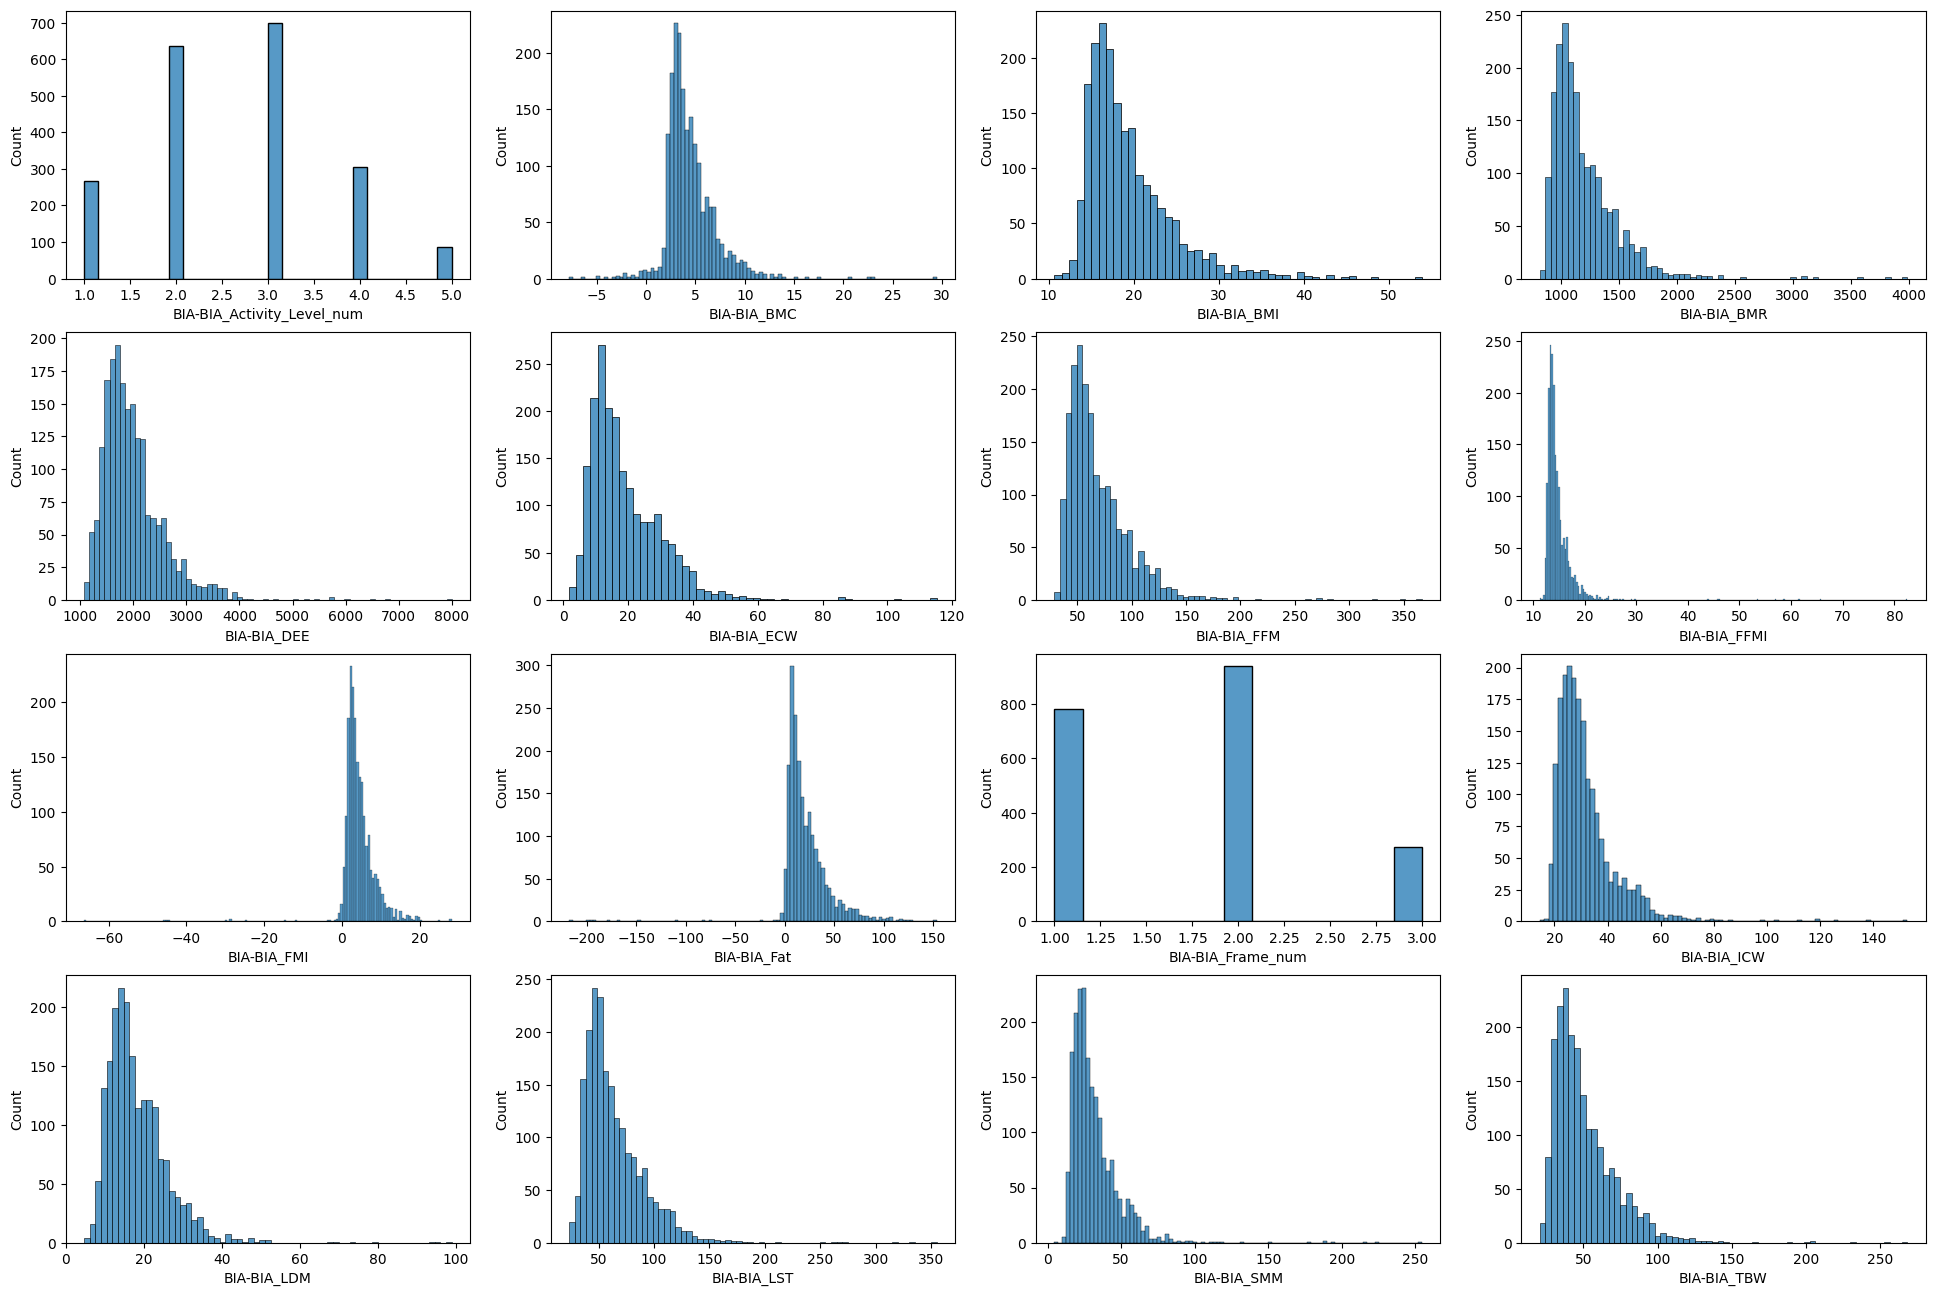

In [194]:
fig, axes = plt.subplots(4, 4, figsize=(24, 16))
axes = axes.flatten()
for i, col in enumerate(bia_cols):
    sns.histplot(x=col, data=eda.to_pandas(), ax=axes[i])

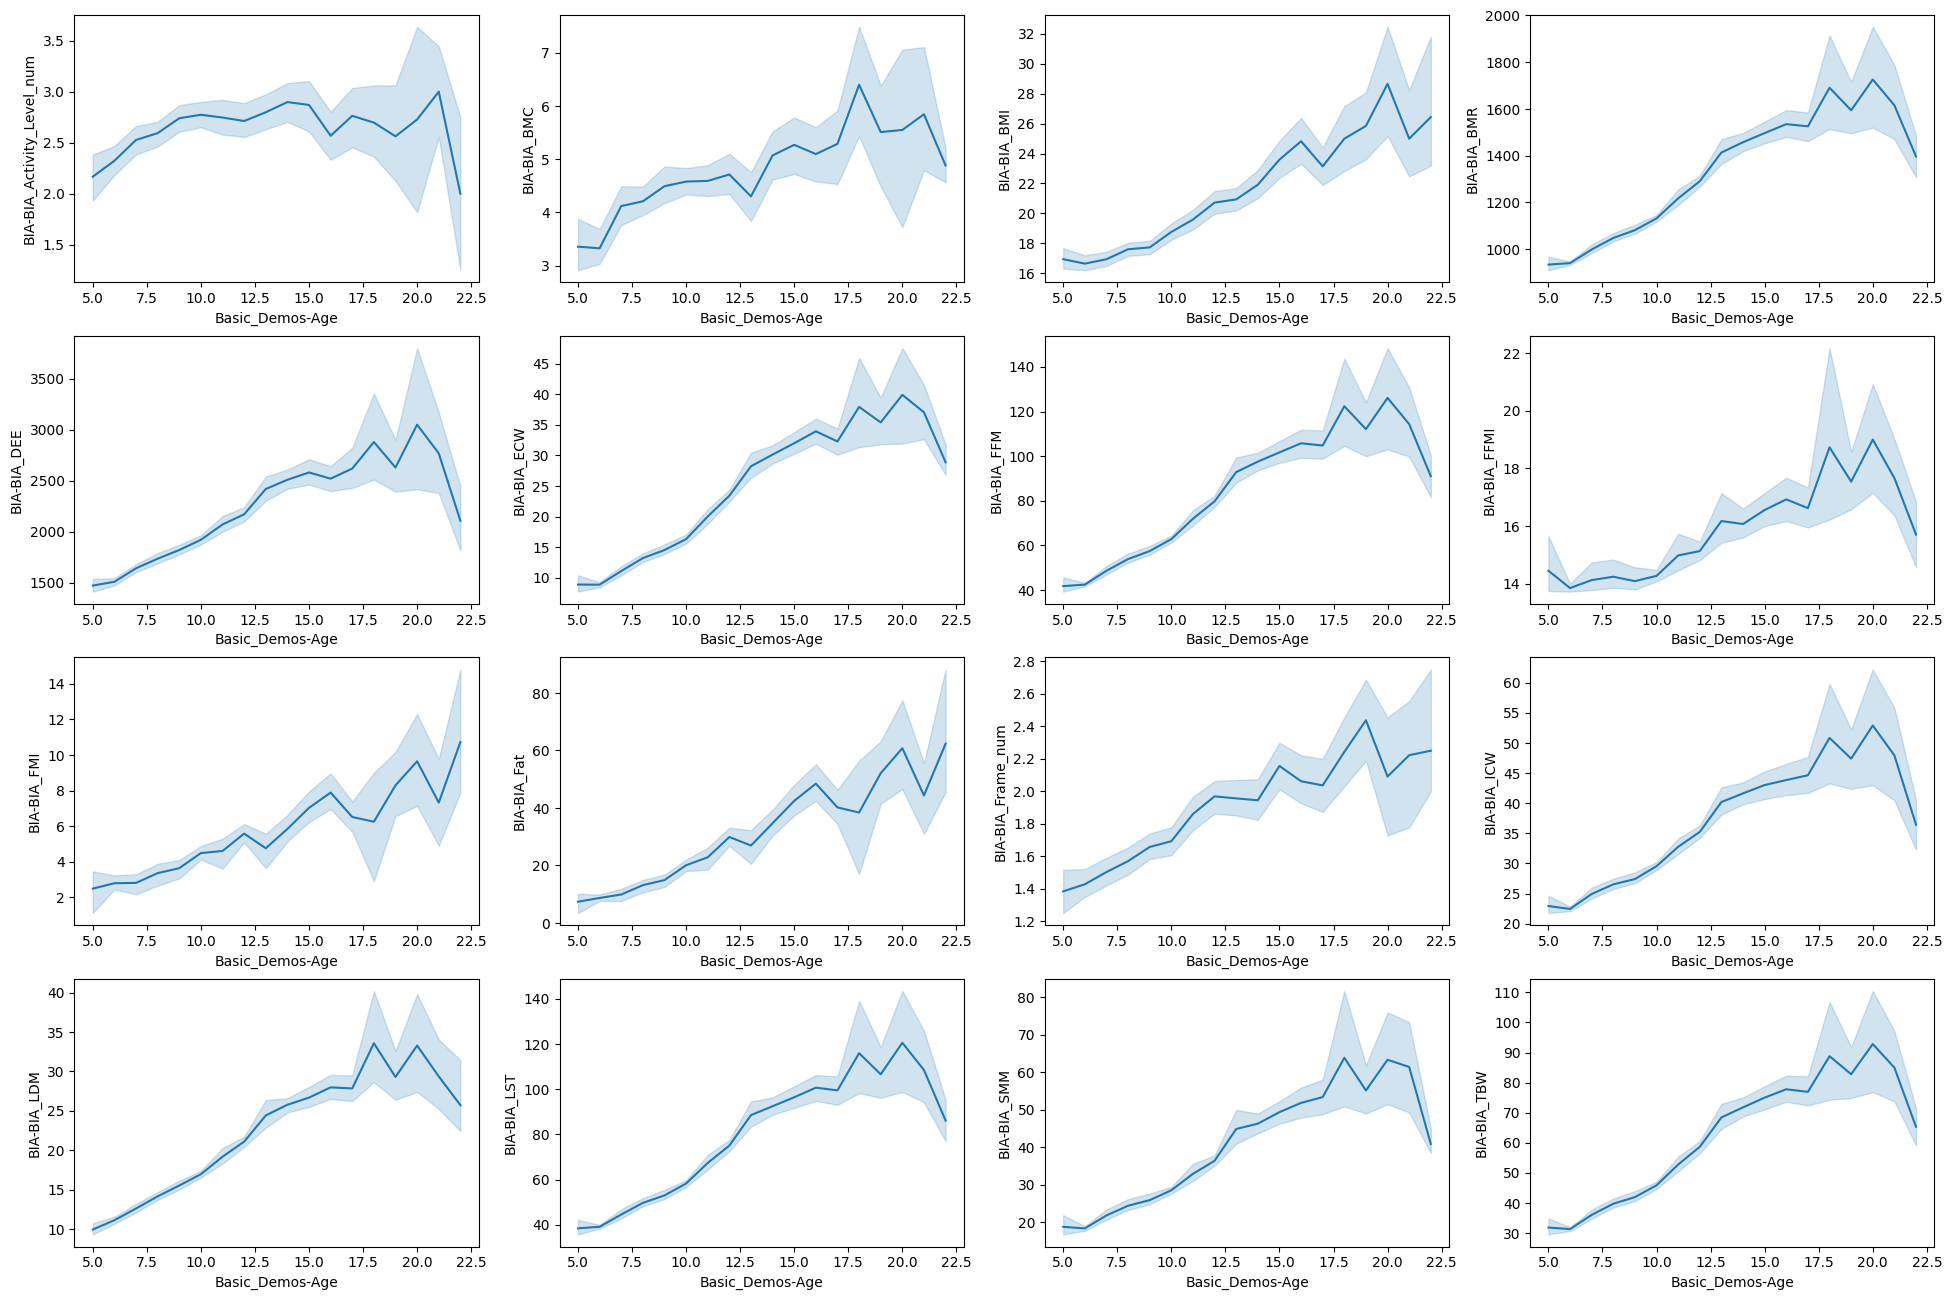

In [178]:
fig, axes = plt.subplots(4, 4, figsize=(24, 16))
axes = axes.flatten()
for i, col in enumerate(bia_cols):
    sns.lineplot(x="Basic_Demos-Age", y=col, data=eda.to_pandas(), ax=axes[i])

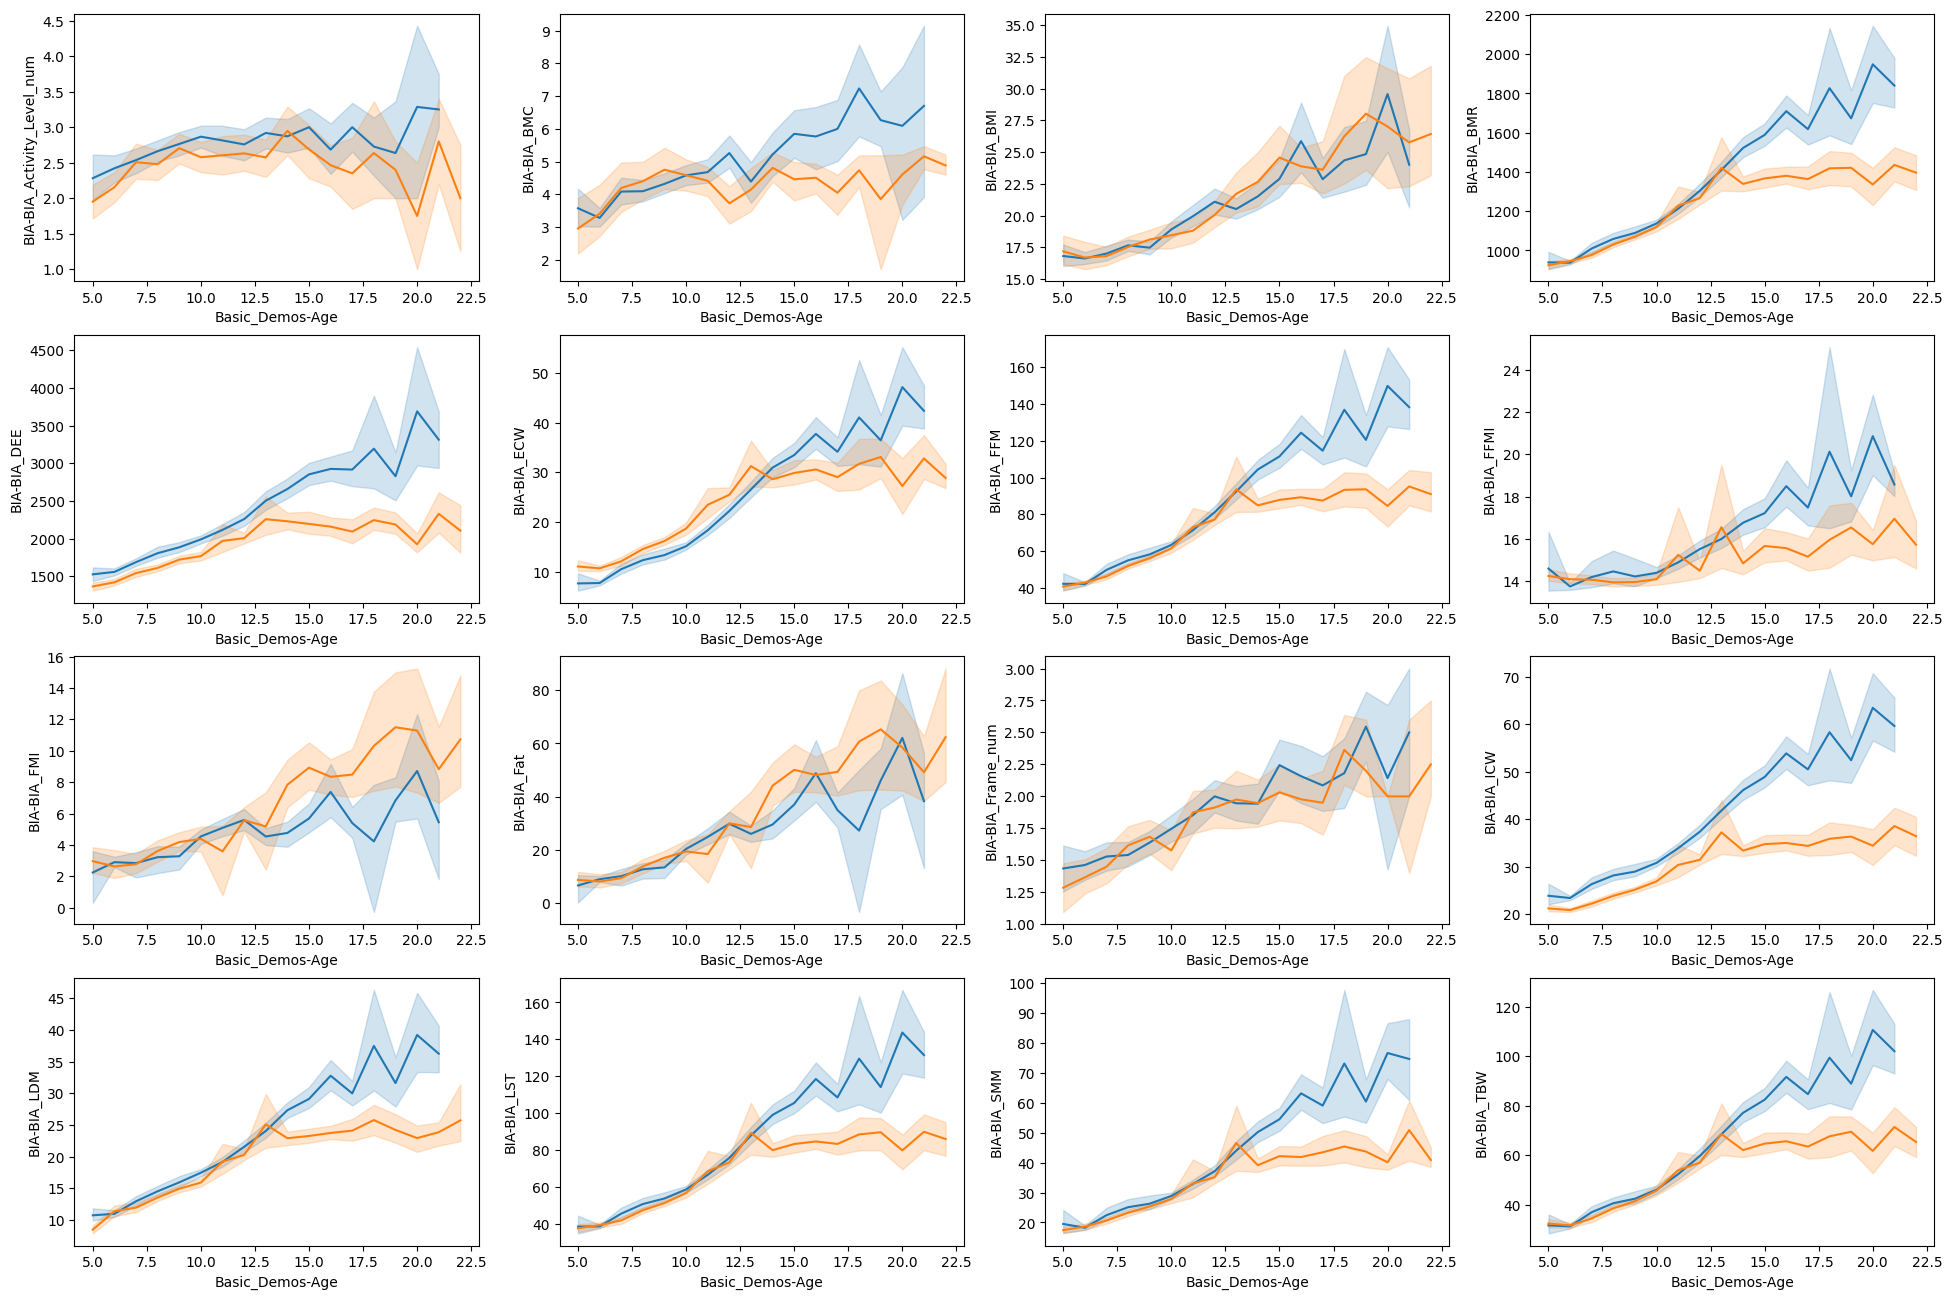

In [180]:
fig, axes = plt.subplots(4, 4, figsize=(24, 16))
axes = axes.flatten()
for i, col in enumerate(bia_cols):
    sns.lineplot(x="Basic_Demos-Age", y=col, data=eda.filter(pl.col("Basic_Demos-Sex") == 0).to_pandas(), ax=axes[i])
    sns.lineplot(x="Basic_Demos-Age", y=col, data=eda.filter(pl.col("Basic_Demos-Sex") == 1).to_pandas(), ax=axes[i])

### PAQ_A-PAQ_A_Total

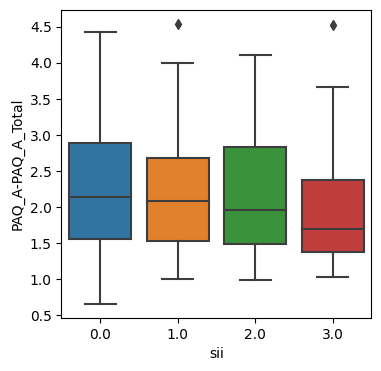

In [182]:
boxplot_sii(trn_df, "PAQ_A-PAQ_A_Total")

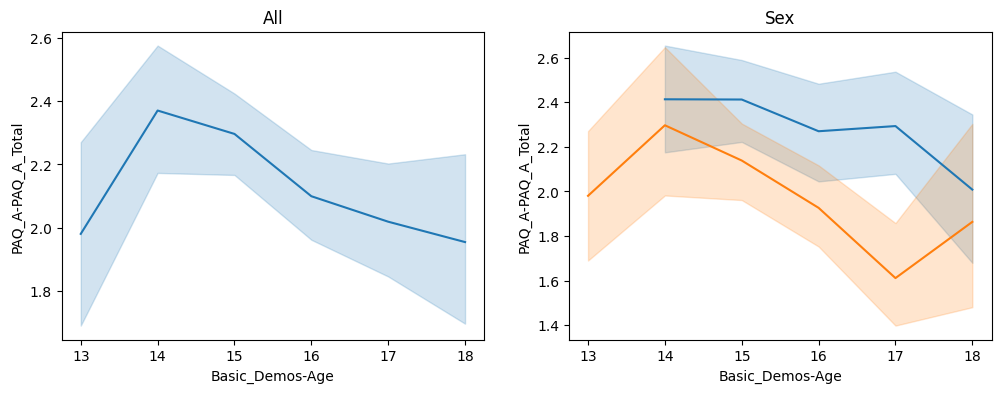

In [184]:
lineplot_age(trn_df, "PAQ_A-PAQ_A_Total")

### PAQ_C-PAQ_C_Total

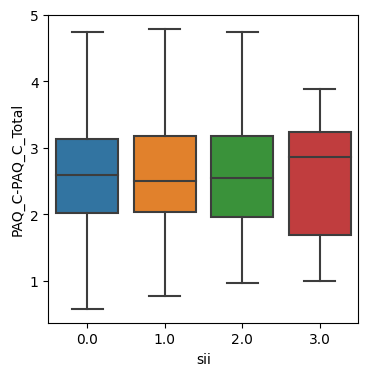

In [183]:
boxplot_sii(trn_df, "PAQ_C-PAQ_C_Total")

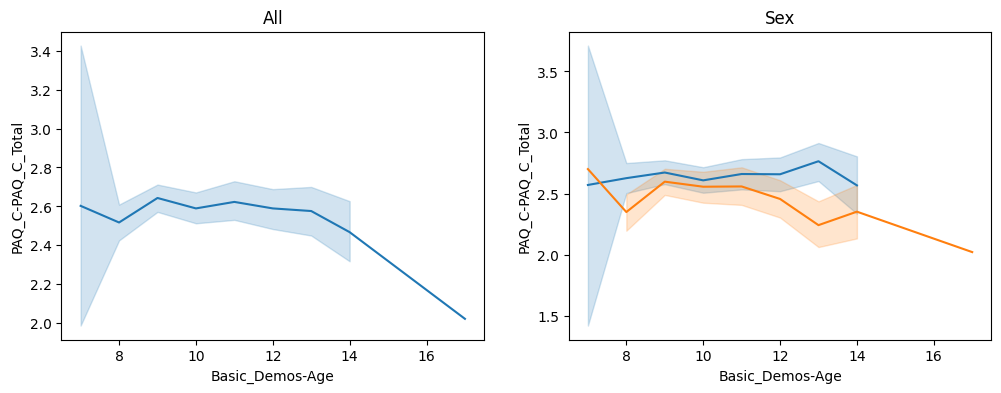

In [185]:
lineplot_age(trn_df, "PAQ_C-PAQ_C_Total")

### SDS-SDS_Total_Raw

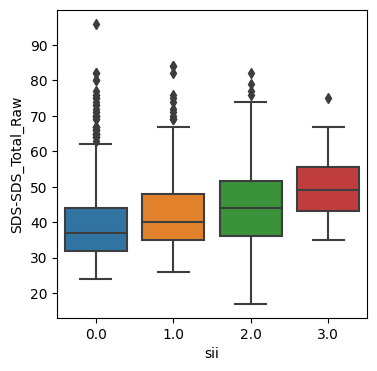

In [186]:
boxplot_sii(trn_df, "SDS-SDS_Total_Raw")

### PreInt_EduHx-computerinternet_hoursday

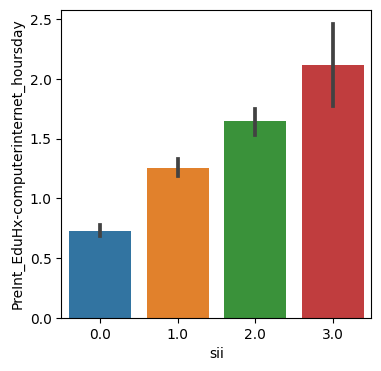

In [191]:
plt.figure(figsize=(4, 4))
sns.barplot(x="sii", y="PreInt_EduHx-computerinternet_hoursday", data=trn_df.to_pandas())
plt.show()

In [169]:
trn_df

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,str,i64,i64,str,i64,str,f64,f64,f64,f64,i64,i64,i64,str,i64,i64,i64,str,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,str,i64,f64,f64,…,f64,f64,f64,f64,f64,str,f64,str,f64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,i32
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,…,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,…,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,…,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ff8a2de4""","""Fall""",13,0,"""Spring""",60,"""Fall""",16.36246,59.5,82.4,null,71,70,104,null,null,null,null,"""Fall""",16,0,18.0,1,19.9,2,10,1,8.0,1,9.0,1,12.0,1,"""Fall""",3,4.52277,16.3642,…,33.3709,17.9797,66.2889,29.779,52.832,null,null,"""Winter""",3.26,"""Winter""",3,3,3,2,3,2,2,2,2,1,2,0,2,0,1,0,2,1,1,0,32,"""Winter""",35,50,"""Fall""",1,1
"""ffa9794a""","""Winter""",10,0,null,null,"""Spring""",18.764678,53.5,76.4,27.0,60,78,118,null,null,null,null,"""Spring""",0,0,null,null,null,null,4,0,0.0,0,0.0,0,12.0,1,"""Spring""",null,null,null,…,null,null,null,nul

<Axes: xlabel='Physical-BMI', ylabel='Basic_Demos-Age'>

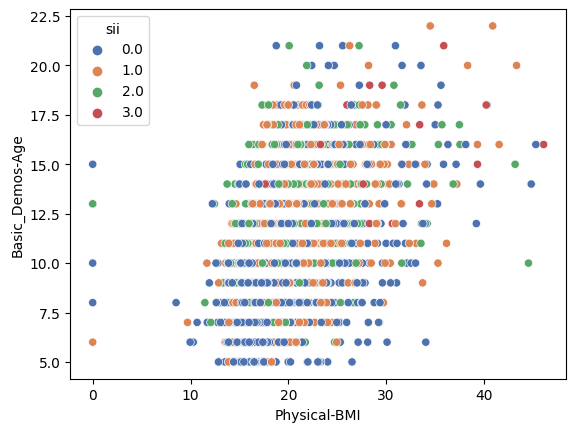

In [172]:
sns.scatterplot(x="Physical-BMI", y="Basic_Demos-Age", data=trn_df.to_pandas(), hue="sii", palette="deep")

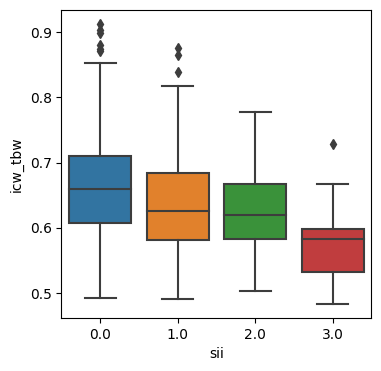

In [180]:
from preprocess.table import remove_outlier
eda = (
    remove_outlier(trn_df)
    .with_columns(
        (pl.col("Physical-BMI") * pl.col("Basic_Demos-Age")).alias("bmi_age"),
        (pl.col("PreInt_EduHx-computerinternet_hoursday") * pl.col("Basic_Demos-Age")).alias("internet_hours_age"),
        (pl.col("PreInt_EduHx-computerinternet_hoursday") * pl.col("Physical-BMI")).alias("internet_hours_bmi")
    )
    .with_columns(
        (pl.col("BIA-BIA_Fat") / pl.col("BIA-BIA_BMI")).alias("bfp_bmi"),
        (pl.col("BIA-BIA_ICW") / pl.col("BIA-BIA_TBW")).alias("icw_tbw")
    )
)
boxplot_sii(eda, "icw_tbw")